In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
scope = "user-library-read"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [3]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [4]:
infile = open('pickled_files/df.pickle','rb')
df = pickle.load(infile)
infile.close()
df.set_index('id', inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5268 entries, 1gyee1JuFFiP476LQpRMYU to 0SfpnyHLyrUlBTgGxgmKVR
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5268 non-null   float64
 1   energy            5268 non-null   float64
 2   key               5268 non-null   object 
 3   loudness          5268 non-null   float64
 4   mode              5268 non-null   object 
 5   speechiness       5268 non-null   float64
 6   acousticness      5268 non-null   float64
 7   instrumentalness  5268 non-null   float64
 8   liveness          5268 non-null   float64
 9   valence           5268 non-null   float64
 10  tempo             5268 non-null   float64
 11  duration_ms       5268 non-null   float64
 12  time_signature    5268 non-null   object 
 13  genre             5268 non-null   object 
dtypes: float64(10), object(4)
memory usage: 617.3+ KB


In [6]:
categorical_columns = list(df.drop('genre', axis = 1).select_dtypes('object').columns)
numerical_columns = list(df.drop('genre', axis = 1).select_dtypes(exclude = 'object').columns)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['genre'], axis=1),
                                                    df.genre,
                                                   random_state=9)

In [8]:
y_train.value_counts(normalize=True)

hip-hop      0.418881
alt-metal    0.240445
rock         0.209567
pop          0.131106
Name: genre, dtype: float64

In [ ]:
def evaluation_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"F1 Score: {f1_score(y_test, model.predict(X_test), average = 'macro')}")
    plot_confusion_matrix(model, X_test, y_test, cmap='GnBu',xticks_rotation='vertical')

**First Simple Model**

In [ ]:
lr = LogisticRegression(random_state=9)
ss = StandardScaler()
lr.fit(ss.fit_transform(X_train), y_train)

In [ ]:
lr.classes_

In [ ]:
print('Training')
evaluation_report(lr, ss.fit_transform(X_train), y_train)

In [ ]:
print('Testing')
evaluation_report(lr, ss.transform(X_test), y_test)

<hl>

In [10]:
from imblearn.pipeline import Pipeline as imbpipeline

In [ ]:
#Create pipelines
numerical_pipeline = imbpipeline(verbose=False,steps=[
                                ('ss', StandardScaler())
                            ])

categorical_pipeline = imbpipeline(verbose=False,steps=[
                            ('ohe', OneHotEncoder(drop='first',
                                                 sparse=False,))
                            ])

col_trans = ColumnTransformer(verbose=False,transformers=[
    ('numerical', numerical_pipeline, numerical_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])

col_ohe_solo = ColumnTransformer(verbose=False,transformers=[
    ('categorical', categorical_pipeline, categorical_columns)
])


<hl>

**Second Model**

In [ ]:
pipe_log = imbpipeline(verbose=False, steps=[
    ('col_trans', col_trans),
    ('lr', LogisticRegression(max_iter = 10000, random_state=9, class_weight='balanced'))
])

param_grid = [
    {
     'lr__penalty' : ['l1','l2'],
     'lr__C' : [.75,.5,.25],
     'lr__solver' : ['saga','sag', 'lbfgs']
    }, 
]

gs_lr = GridSearchCV(pipe_log, param_grid = param_grid, 
                        scoring = 'f1_macro', n_jobs=-1, verbose=True)
gs_lr.fit(X_train, y_train)

In [ ]:
gs_lr.best_params_

In [ ]:
print('Training')
evaluation_report(log_model_2, X_train, y_train)

In [ ]:
print('Testing')
evaluation_report(log_model_2, X_test, y_test)

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
ohe = OneHotEncoder(drop='first', sparse=False)
sm = SMOTE(random_state = 9)


In [44]:
train_ohe = ohe.fit_transform(X_train[categorical_columns])
test_ohe = ohe.transform(X_test[categorical_columns])
train_ohe = X_train[numerical_columns].reset_index().join(pd.DataFrame(train_ohe)).set_index('id')

train_sm = sm.fit_resample(train_ohe, y_train)
test_ohe = X_test[numerical_columns].reset_index().join(pd.DataFrame(test_ohe)).set_index('id')

**Model 3**

In [89]:
xgbc = XGBClassifier(random_state = 9, n_jobs = -1)
params = {
    'max_depth': [1,2],
    'learning_rate': [.1,.05,.01,.005],
    'n_estimators': range(180,220,20),
    'booster': ['gbtree', 'gblinear', 'dart']
}
#Run gridsearch
gs_xgbc = GridSearchCV(xgbc, param_grid=params, scoring='f1_macro', n_jobs =-1 )

In [90]:
gs_xgbc.fit(train_sm[0], train_sm[1])

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=9,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=Non

In [91]:
gs_xgbc.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 200}

In [92]:
gs_xgbc.score(train_sm[0],train_sm[1])

0.7890777792693433

In [93]:
gs_xgbc.score(test_ohe, y_test)

0.6793578047998373

F1 Score: 0.7890777792693433
Accuracy Score: 0.7891238670694865


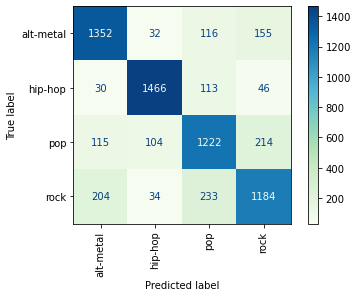

In [94]:
evaluation_report(gs_xgbc, train_sm[0], train_sm[1])

F1 Score: 0.6793578047998373
Accuracy Score: 0.7327258921791951


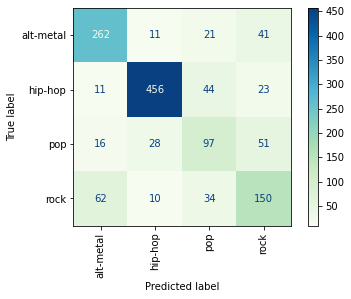

In [95]:
evaluation_report(gs_xgbc, test_ohe, y_test)

**Model 4**

In [105]:
gbclf = GradientBoostingClassifier(random_state = 9)

param_grid = [
    {
     'n_estimators' : [50,75,100,125],
     'learning_rate' : [.05, .1, .15, .2],
     'max_depth': [1,2]
    }, 
]

gs_gbclf = GridSearchCV(gbclf, param_grid = param_grid, 
                        scoring = 'f1_macro', n_jobs=-1, verbose=True)
gs_gbclf.fit(train_sm[0], train_sm[1])

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  5.1min finished


GridSearchCV(estimator=GradientBoostingClassifier(random_state=9), n_jobs=-1,
             param_grid=[{'learning_rate': [0.05, 0.1, 0.15, 0.2],
                          'max_depth': [1, 2],
                          'n_estimators': [50, 75, 100, 125]}],
             scoring='f1_macro', verbose=True)

In [106]:
gs_gbclf.best_params_

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 125}

F1 Score: 0.8267180681715205
Accuracy Score: 0.8268882175226586


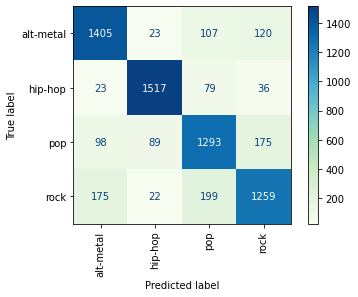

In [107]:
evaluation_report(gs_gbclf, train_sm[0], train_sm[1])

F1 Score: 0.6899248415535542
Accuracy Score: 0.744874715261959


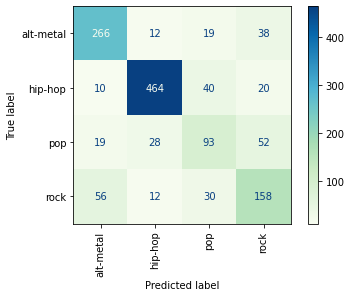

In [108]:
evaluation_report(gs_gbclf, test_ohe, y_test)

**Model 5**

In [115]:
lr = LogisticRegression(max_iter = 10000, random_state=9, class_weight='balanced')

param_grid = [
    {
     'penalty' : ['l1','l2'],
     'C' : [.75,.5,.25],
     'solver' : ['saga','sag', 'lbfgs']
    }, 
]

gs_lr2 = GridSearchCV(lr, param_grid = param_grid, 
                        scoring = 'f1_macro', n_jobs=-1, verbose=True)
gs_lr2.fit(train_ohe, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.0min


KeyboardInterrupt: 

In [110]:
evaluation_report(gs_lr2, train_ohe, y_train)

In [113]:
evaluation_report(gs_lr2, test_ohe, y_test)

3951

**Model 6**

In [ ]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [ ]:
xgbc2 = XGBClassifier(random_state = 9, n_jobs = -1)
params = {
    'max_depth': [1,2],
    'learning_rate': [.1,.05,.01,.005],
    'n_estimators': range(180,220,20),
    'booster': ['gbtree', 'gblinear', 'dart']
    'sample_weights': classes_weights
}
#Run gridsearch
gs_xgbc2 = GridSearchCV(xgbc2, param_grid=params, scoring='f1_macro', n_jobs =-1 )
gs_xgbc2.fit(train_ohe, y_train)

In [ ]:
evaluation_report(gs_xgbc2, train_ohe, y_train)

In [ ]:
evaluation_report(gs_xgbc2, test_ohe, y_test)